In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from collections import Counter
from scipy import interp
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
table = pd.read_csv('creditcard.csv')

# Exploratory data analysis

In [ ]:
table.isnull().sum().all()

Null elements are not present in the dataset.

In [ ]:
table.head()

In [ ]:
table.tail()

In [ ]:
table.info()

In [ ]:
table.describe()

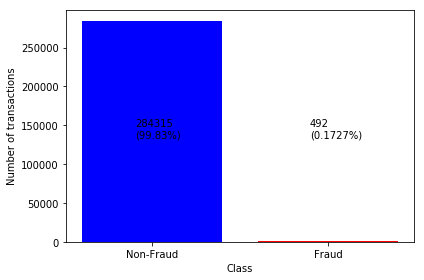

In [3]:
plt.bar(['Non-Fraud','Fraud'], table['Class'].value_counts(), color=['b','r'])
plt.xlabel('Class')
plt.ylabel('Number of transactions')
plt.annotate('{}\n({:.4}%)'.format(table['Class'].value_counts()[0], 
                                         table['Class'].value_counts()[0]/table['Class'].count()*100),
             (0.20, 0.45), xycoords='axes fraction')
plt.annotate('{}\n({:.4}%)'.format(table['Class'].value_counts()[1], 
                                         table['Class'].value_counts()[1]/table['Class'].count()*100),
             (0.70, 0.45), xycoords='axes fraction')
plt.tight_layout()
plt.show()

The dataset has only two classes: fraud or non-fraud. The classes are highly umbalanced with 99.83% of observations belonging to non-fraudulent transactions and only 0.17% of observations labeled as fraudulent. This issue will be adressed later with a method for balancing classes.

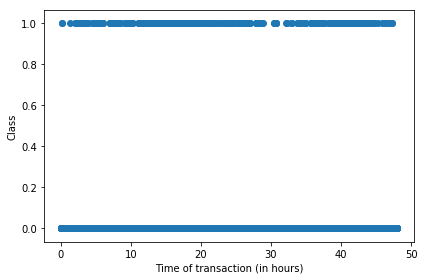

In [4]:
plt.scatter(table['Time']/(60*60), table['Class'])
plt.xlabel('Time of transaction (in hours)')
plt.ylabel('Class')

plt.tight_layout()
plt.show()

The data was collected over the period of 2 days and, apparently, the 'Time' variable isn't a good predictor for frauds. As seen above, the pattern for both non-fradulent and fraudulent transactions seems to be random regarding the hour of the day.

Number of outliers below the lower bound:  0  (0.0%)
Number of outliers above the upper bound:  31904  (11.2%)


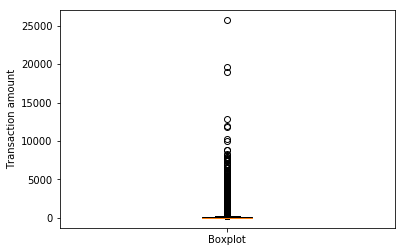

In [5]:
plt.boxplot(table['Amount'], labels = ['Boxplot'])
plt.ylabel('Transaction amount')
plt.plot()

amount = table[['Amount']].sort_values(by='Amount')
q1, q3 = np.percentile(amount,[25,75])
iqr = q3 - q1
lower_bound = q1 -(1.5 * iqr) 
upper_bound = q3 +(1.5 * iqr)

print('Number of outliers below the lower bound: ', amount[amount['Amount'] < lower_bound].count()[0],
     ' ({:.4}%)'.format(amount[amount['Amount'] < lower_bound].count()[0] / amount['Amount'].count() * 100))
print('Number of outliers above the upper bound: ', amount[amount['Amount'] > upper_bound].count()[0],
      ' ({:.4}%)'.format(amount[amount['Amount'] > upper_bound].count()[0] / amount['Amount'].count() * 100))

31904 outliers found using the interquartile range method, which represents 11.2% of the observations. Removing them from the dataset would be a bad idea due to the loss of a large amount of information for the machine learning models.

In [6]:
table[table['Class']==1].where(table['Amount']>upper_bound).count()['Amount']

91

In addition to that, only 91 out of 31904 outliers are classified as frauds.

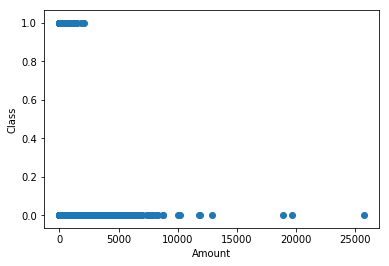

In [7]:
plt.scatter(table['Amount'], table['Class'])
plt.xlabel('Amount')
plt.ylabel('Class')
plt.show()

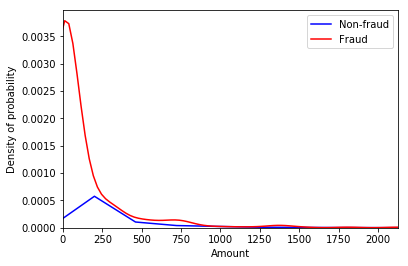

In [8]:
target_0 = table.loc[table['Class'] == 0]
target_1 = table.loc[table['Class'] == 1]
ax1=sns.distplot(target_0[['Amount']], hist=False, color='b', label='Non-fraud')
ax2=sns.distplot(target_1[['Amount']], hist=False, color='r', label='Fraud')
ax1.set_xlim(0, max(table[table['Class']==1]['Amount']))
ax2.set_xlim(0, max(table[table['Class']==1]['Amount']))
plt.legend()
plt.xlabel('Amount')
plt.ylabel('Density of probability')
plt.show()

In [9]:
table.loc[table['Class'] == 1]['Amount'].describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

We can see that fraudulent transactions are highly concentrated at smaller values when compared to non-fraudulent transactions.

In [ ]:
heatmap = sns.heatmap(table.corr(method='spearman'))

In [ ]:
table.corrwith(table.Class, method='spearman').plot.bar(
        figsize = (20, 10), title = "Correlation with class", fontsize = 15,
        rot = 45, grid = True, color=['blue'])
plt.show()

We can see that all features have very low correlation coefficients among each other, and especially low correlation with the 'Class' feature. This was already expected since the data was processed using PCA.

# Balancing the classes

Before balancing the classes we need to split the observations into a training set and a testing set. ***This is extremely important!*** We can only balance the classes after we set some observations aside to be used as a test set! Otherwise, the models might use part of the test data during the training, which will lead to overfitting. Let's be smart and avoid that! :)

In [10]:
y = table['Class']
X = table.drop(columns=['Class'])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

We are going to test three types of resampling methods: [random undersampling](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.under_sampling.RandomUnderSampler.html#imblearn.under_sampling.RandomUnderSampler), [random oversampling](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.RandomOverSampler.html#imblearn.over_sampling.RandomOverSampler) and [Synthetic Minority Over-sampling (SMOTE)](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html#imblearn.over_sampling.SMOTE). The image below depicts how undersampling and oversampling works and it is very intuitive to understand. SMOTE is similar to oversampling but instead of copying the same original points randomly, the algorithm creates new points close to the original ones.

<img src="Images/resampling.png">

[Image Source](https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets)

### Random undersampling

In [12]:
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42, replacement=False)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

Checking If classes are balanced:

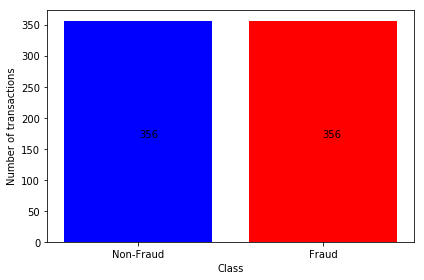

In [13]:
plt.bar(['Non-Fraud','Fraud'], [Counter(y_rus)[0], Counter(y_rus)[1]], color=['b','r'])
plt.xlabel('Class')
plt.ylabel('Number of transactions')
plt.annotate('{}'.format(Counter(y_rus)[0]), (0.25, 0.45), xycoords='axes fraction')
plt.annotate('{}'.format(Counter(y_rus)[1]), (0.75, 0.45), xycoords='axes fraction')

plt.tight_layout()
plt.show()

In [14]:
assert Counter(y_rus)[1] == Counter(y_train)[1] #Checking if they have the same number of fraud cases

### Random oversampling

In [15]:
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

Checking If classes are balanced:

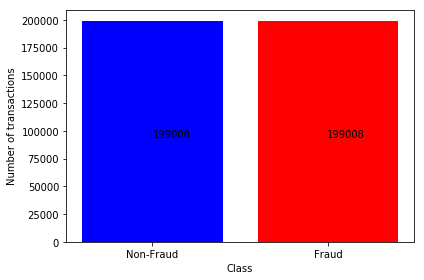

In [16]:
plt.bar(['Non-Fraud','Fraud'], [Counter(y_ros)[0], Counter(y_ros)[1]], color=['b','r'])
plt.xlabel('Class')
plt.ylabel('Number of transactions')
plt.annotate('{}'.format(Counter(y_ros)[0]), (0.25, 0.45), xycoords='axes fraction')
plt.annotate('{}'.format(Counter(y_ros)[1]), (0.75, 0.45), xycoords='axes fraction')

plt.tight_layout()
plt.show()

In [17]:
assert Counter(y_ros)[0] == Counter(y_train)[0] #Checking if they have the same number of non-fraud cases

### Synthetic Minority Over-sampling (SMOTE)

A quick explanation of how SMOTE works: it consists of synthesizing elements for the minority class using the existing ones. It randomly chooses a point from the minority class and computes the k-nearest neighbors (default = 5) for this point. The synthetic points are added between the chosen point and its neighbors by choosing a factor between 0 and 1 to multiply the distance. This process can be seen below.

<img src="Images/smote.png">

[Image Source](https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets)

In [18]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

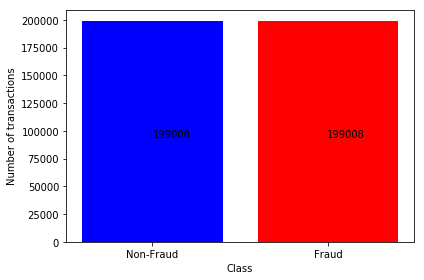

In [19]:
plt.bar(['Non-Fraud','Fraud'], [Counter(y_smote)[0], Counter(y_smote)[1]], color=['b','r'])
plt.xlabel('Class')
plt.ylabel('Number of transactions')
plt.annotate('{}'.format(Counter(y_smote)[0]), (0.25, 0.45), xycoords='axes fraction')
plt.annotate('{}'.format(Counter(y_smote)[1]), (0.75, 0.45), xycoords='axes fraction')

plt.tight_layout()
plt.show()

In [20]:
assert Counter(y_smote)[0] == Counter(y_train)[0] #Checking if they have the same number of non-fraud cases

#### Checking the difference between random oversampling and SMOTE

In [21]:
def plot_2d_space(X, y, label='Classes'):
    '''Plots the data points in a 2D scatterplot.'''
    colors = ['blue', 'red']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(X[y==l, 0], X[y==l, 1], c=c, label=l, marker=m)
    plt.title(label)
    plt.legend(loc='best')
    plt.show()

Because the dataset has many features and our graphs will be 2D, we will reduce the size of the dataset using Principal Component Analysis (PCA):

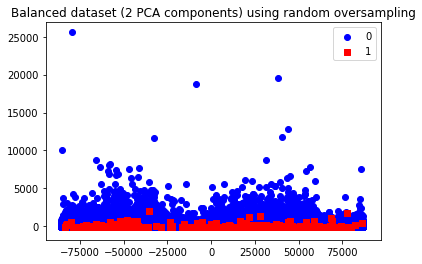

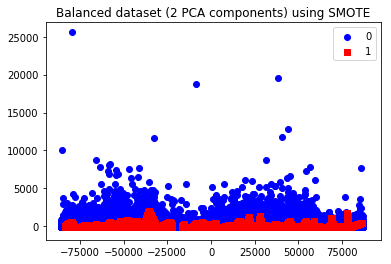

In [22]:
std_scale = StandardScaler().fit(X_train)

pca = PCA(n_components=2)
X_ros_pca = pca.fit_transform(X_ros)
X_smote_pca = pca.fit_transform(X_smote)

plot_2d_space(X_ros_pca, y_ros, 'Balanced dataset (2 PCA components) using random oversampling')
plot_2d_space(X_smote_pca, y_smote, 'Balanced dataset (2 PCA components) using SMOTE')

If you look closely, you can see that some of the observations tagged as 1 (fraudulent transactions) are present in different coordinates on the graphs above. This is due to the new fraudulent observations created by the SMOTE algorithm.

# Models

Before we begin let's first create a function to perform feature scaling because some models need this prior to fitting.

In [23]:
def feature_scaling(X_train, X_test=X_test):
    std_scale = StandardScaler().fit(X_train)
    X_train_std = std_scale.transform(X_train)
    X_test_std = std_scale.transform(X_test)
    return X_train_std, X_test_std

In [24]:
X_train_rus_std, X_test_rus_std = feature_scaling(X_rus)
X_train_ros_std, X_test_ros_std = feature_scaling(X_ros)
X_train_smote_std, X_test_smote_std = feature_scaling(X_smote)

In [25]:
classifiers = []

classifiers.append(('Logistic Regression', LogisticRegression(random_state=42)))
classifiers.append(('Naive Bayes', GaussianNB()))
#classifiers.append(('KNN', KNeighborsClassifier()))
#classifiers.append(('SVM', SVC(random_state=42, probability=True)))
classifiers.append(('Decision Tree', DecisionTreeClassifier(random_state=42)))
classifiers.append(('Random Forest', RandomForestClassifier(random_state=42)))

In [26]:
from sklearn import svm
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from scipy import interp

def plot_ROC_curve(classifier, X, y, cv_n_splits=5):
    '''Plots the ROC curve with cross validation'''
    
    # Classification and ROC analysis

    # Run classifier with cross-validation and plot ROC curves
    cv = StratifiedKFold(n_splits=cv_n_splits)
    name = classifier[0]
    classifier = classifier[1]

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.4f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label='Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label='$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve - model: ' + name)
    plt.legend(loc="lower right")
    plt.show()

#### Results using undersampling

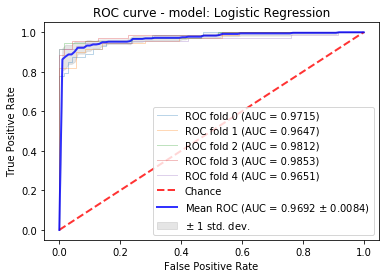

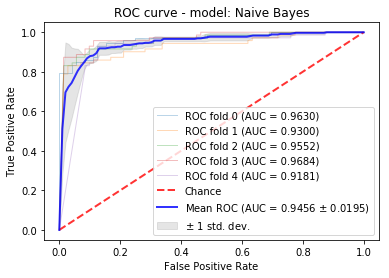

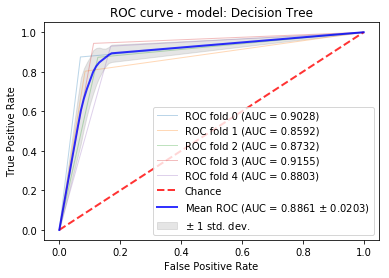

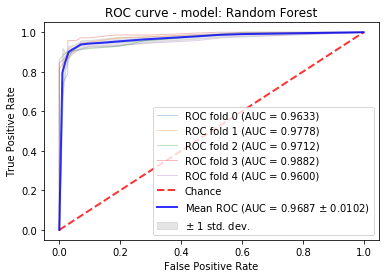

In [27]:
for clf in classifiers:
    plot_ROC_curve(clf, X_train_rus_std, y_rus) 

#### Results using oversampling

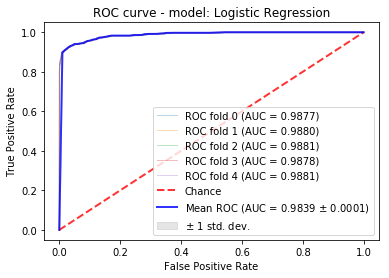

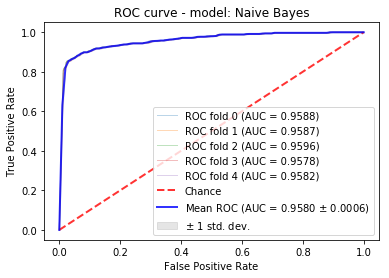

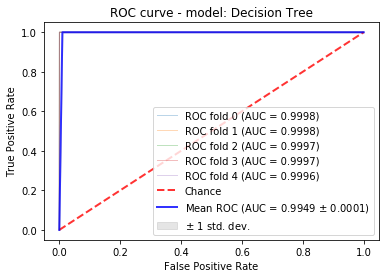

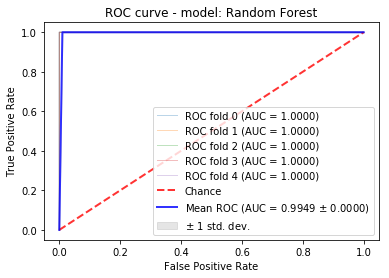

In [28]:
for clf in classifiers:
    plot_ROC_curve(clf, X_train_ros_std, y_ros)

#### Results using SMOTE

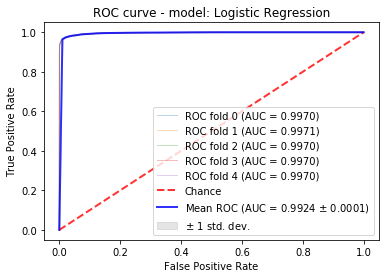

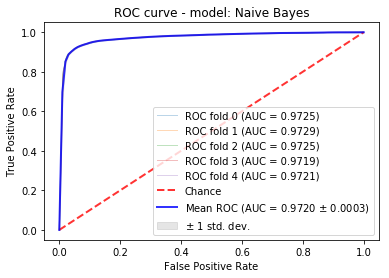

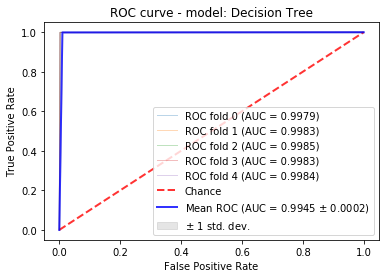

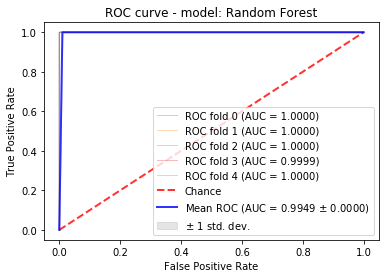

In [30]:
for clf in classifiers:
    plot_ROC_curve(clf, X_train_smote_std, y_smote) 